# Linear Support Vector Machine (SVM)

We've now seen how to optimise analytic functions using PyTorch's optimisers, and in the previous labs and exercises we played with training simple machine learning models with hand-coded gradient descent. Let's put everything together and implement a Soft-Margin Linear Support Vector Machine, which we'll train on some artifically generated data using a range of optimisers.

In [1]:
# We're going to use a library called celluloid to make animations that work on colab
try: 
    from celluloid import Camera
except:
    !pip install celluloid

from IPython.display import HTML
import torch
import torch.optim as optim

## SVM Recap

Recall that an SVM tries to find the maximum margin hyperplane which separates the data classes. For a soft margin SVM
where $\textbf{x}$ is our data, we minimize:

\begin{equation}
\left[\frac 1 n \sum_{i=1}^n \max\left(0, 1 - y_i(\textbf{w}\cdot \textbf{x}_i - b)\right) \right] + \lambda\lVert \textbf{w} \rVert^2
\end{equation}

We can formulate this as an optimization over our weights $\textbf{w}$ and bias $b$, where we minimize the
hinge loss subject to a level 2 weight decay term. The hinge loss for some model outputs
$z = \textbf{w}\textbf{x} + b$ with targets $y$ is given by:

\begin{equation}
\ell(y,z) = \max\left(0, 1 - yz \right)
\end{equation}

First, complete the following function to implement the hinge loss for batches of predictions `y_pred` and targets `y_true`. You should return the mean of the hinge loss across the batch. Note that this is a binary problem with labels are chosen to be $\{-1,1\}$.

In [2]:
def hinge_loss(y_pred, y_true):
    val = 1-y_pred*y_true
    return max(torch.tensor(0.0,requires_grad=True),1-y_pred*y_true)

## Defining the SVM

Defining the SVM is pretty simple - it's just a basic linear classifier like a Perceptron; what distinguishes it is the loss.  We'll wrap it up in a function:

In [3]:
def svm(x, w, b):
    h = (w*x).sum(1) + b
    return h

Creating Synthetic Data
-----------------------------------------------

Now for some data, 1024 samples should do the trick. We normalise here so that our random init is in the same space as
the data:

In [4]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs

X, Y = make_blobs(n_samples=1024, centers=2, cluster_std=1.2, random_state=1)
X = (X - X.mean()) / X.std()
Y[np.where(Y == 0)] = -1
X, Y = torch.FloatTensor(X), torch.FloatTensor(Y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


For the first time, we're going to do proper mini-batch gradient descent. As such, we actually need to be able to produce batches of data. PyTorch has the concept of datasets (which represent entire collections of data) and data loaders (which allow us to iterate batches of data from a dataset). This allows the framework to do all the hard work for us:

In [5]:
from torch.utils import data

dataset = data.TensorDataset(X,Y) # create your datset
dataloader = data.DataLoader(dataset, batch_size=32, shuffle=True) # create your dataloader

Visualizing the Training
----------------------------------------

We now aim to create a nice visualisation, such as the one below, that shows what happens as our SVM learns.

![svmgif](https://raw.githubusercontent.com/ecs-vlc/torchbearer/master/docs/_static/img/svm_fit.gif)

The code for the visualisation (using [pyplot](https://matplotlib.org/api/pyplot_api.html)) is a bit ugly but we'll
try to explain it to some degree. First, we need a mesh grid `xy` over the range of our data:

In [6]:
delta = 0.01
x = np.arange(X[:, 0].min(), X[:, 0].max(), delta)
y = np.arange(X[:, 1].min(), X[:, 1].max(), delta)
x, y = np.meshgrid(x, y)
xy = list(map(np.ravel, [x, y]))

Now things get a little strange. We start by evaluating our model over the mesh grid from earlier.

For our outputs $z \in \textbf{Z}$, we can make some observations about the decision boundary. First, that we are
outside the margin if $z \lt -1$ or $z \gt 1$. Conversely, we are inside the margine where $z \gt -1$
or $z \lt 1$. 

This whole process is shown in the function below, which we can call at the end of every epoch. The `camera` takes snapshots of the current plot and is used later to render a video.

In [7]:
import matplotlib
import matplotlib.pyplot as plt

def draw_margin(w, b, camera):
    w = w.data.numpy()
    b = b.data.numpy()

    z = (w.dot(xy) + b).reshape(x.shape)
    z[np.where(z > 1.)] = 4
    z[np.where((z > 0.) & (z <= 1.))] = 3
    z[np.where((z > -1.) & (z <= 0.))] = 2
    z[np.where(z <= -1.)] = 1

    plt.scatter(x=X[:, 0], y=X[:, 1], c="black", s=10)
    plt.contourf(x, y, z, cmap=plt.cm.jet, alpha=0.5)
    camera.snap()

Since we don't know that our data is linearly separable, we would like to use a soft-margin SVM. That is, an SVM for
which the data does not all have to be outside of the margin. This takes the form of a weight decay term,
$\lambda\lVert \textbf{w} \rVert^2$ in the above equation. This term is called weight decay because the gradient
corresponds to subtracting some amount ($2\lambda\textbf{w}$) from our weights at each step. 

Most PyTorch optimisers actually have weight decay built in to them as an option (`weight_decay=...`), so its trivial to incorporate this. 

At this point we are ready to create and train our model. We've written most of the code, but you'll need to implement the forward and backward pass:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


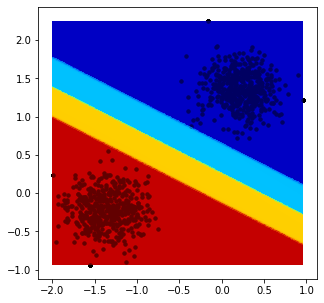

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


RuntimeError: Requested MovieWriter (ffmpeg) not available

In [41]:
batchsize = 64


from torch.utils import data

dataset = data.TensorDataset(X,Y) # create your datset
dataloader = data.DataLoader(dataset, batch_size=batchsize, shuffle=True) # create your dataloader




# Set up drawing
fig = plt.figure(figsize=(5, 5))
camera = Camera(fig)

w = torch.randn(1, 2, requires_grad=True)
b = torch.randn(1, requires_grad=True)

opt = optim.SGD([w,b], lr=0.1, weight_decay=0.01)

for epoch in range(50):
    for batch in dataloader:
        opt.zero_grad()
        for i in range(len(batch[0])):
            xi = torch.tensor(batch[0][i], requires_grad=True)
            yi = torch.tensor(batch[1][i], requires_grad=True)
            loss = hinge_loss(yi,svm(xi,w,b))
            loss.backward()
        opt.step()
    draw_margin(w, b, camera)
    
plt.show()
    
# create the animation and display it

import matplotlib.pyplot as plt
import matplotlib.animation as animation
Writer = animation.writers['pillow']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

anim = camera.animate()
anim.save("Lab 3 - SVM batchsize%s.gif" % batchsize, writer='matplotlib.animation.PillowWriter')
plt.close()
HTML(anim.to_html5_video())

Now do some further experiments. What optimiser and parameters gets you to a good solution the quickest? Do you notice that when the model is near a solution it jitters around upon each step? Can you add some kind of learning rate decay or schedule from the `torch.optim.lr_scheduler` package to reduce the learning rate over time?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()